<a href="https://colab.research.google.com/github/dillonkoh89/GA-Capstone/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
!nvidia-smi

Sat Nov 20 03:56:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    75W / 149W |   4361MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/classification.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall() #Extracts the files into the /tmp folder
zip_ref.close()

In [87]:
# Walk through the classification data directory and list number of files
for dirpath, dirnames, filenames in os.walk("classification"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in 'classification'.
There are 2 directories and 0 images in 'classification/train'.
There are 0 directories and 70 images in 'classification/train/negative'.
There are 0 directories and 70 images in 'classification/train/positive'.
There are 2 directories and 0 images in 'classification/val'.
There are 0 directories and 220 images in 'classification/val/negative'.
There are 0 directories and 220 images in 'classification/val/positive'.
There are 2 directories and 0 images in 'classification/test'.
There are 0 directories and 100 images in 'classification/test/negative'.
There are 0 directories and 100 images in 'classification/test/positive'.
There are 0 directories and 10 images in 'classification/ambiguous'.


In [88]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_dir = "classification/train/"
test_dir = "classification/test/"
val_dir = "classification/val/"

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="binary",
                                                                                image_size=IMG_SIZE)
                                                                                
val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                label_mode="binary",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="binary",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 140 files belonging to 2 classes.
Found 440 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [89]:
train_data.class_names

['negative', 'positive']

In [90]:
val_data.class_names

['negative', 'positive']

In [91]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
], name="data_augmentation")

In [92]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
#outputs = layers.Dense(len(train_data.class_names), activation="sigmoid", name="output_layer")(x) # same number of outputs as classes
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

In [93]:
train_data.class_names

['negative', 'positive']

In [94]:
# Get a summary of our model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainab

In [95]:
# Compile
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
efficientnet_history = model.fit(train_data,
                                           epochs=20, # fit for 5 epochs to keep experiments quick
                                           validation_data=val_data,
                                           validation_steps=int(0.15 * len(val_data))) # evaluate on smaller portion of test data
                                           #callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/20
5/5 [==============================] - 12s 932ms/step - loss: 0.6696 - accuracy: 0.5429 - val_loss: 0.4770 - val_accuracy: 0.9219
Epoch 2/20
5/5 [==============================] - 3s 464ms/step - loss: 0.5954 - accuracy: 0.7000 - val_loss: 0.4764 - val_accuracy: 0.8750
Epoch 3/20
5/5 [==============================] - 3s 526ms/step - loss: 0.5575 - accuracy: 0.7643 - val_loss: 0.4307 - val_accuracy: 0.8906
Epoch 4/20
5/5 [==============================] - 2s 346ms/step - loss: 0.5214 - accuracy: 0.8071 - val_loss: 0.3890 - val_accuracy: 0.9375
Epoch 5/20
5/5 [==============================] - 3s 476ms/step - loss: 0.4529 - accuracy: 0.8643 - val_loss: 0.3381 - val_accuracy: 0.9531
Epoch 6/20
5/5 [==============================] - 2s 416ms/step - loss: 0.4281 - accuracy: 0.8714 - val_loss: 0.3112 - val_accuracy: 0.9531
Epoch 7/20
5/5 [==============================] - 3s 480ms/step - loss: 0.3932 - accuracy: 0.9000 - val_loss: 0.2974 - val_accuracy: 0.9531
Epoch 8/20
5/5 [===

In [96]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(val_data)
results_feature_extraction_model

14/14 [==============================] - 2s 148ms/step - loss: 0.2147 - accuracy: 0.9386


[0.21473976969718933, 0.9386363625526428]

In [97]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

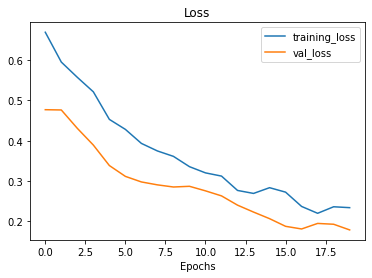

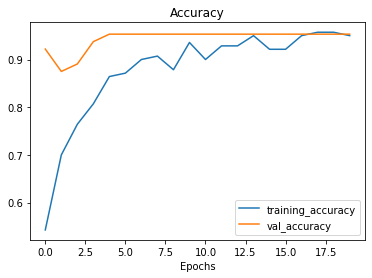

In [98]:
plot_loss_curves(efficientnet_history)

## Making predictions with trained model

In [99]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

7/7 [==============================] - 3s 135ms/step


In [145]:
# How many predictions are there?
len(pred_probs)

200

In [101]:
# What's the shape of our predictions?
pred_probs.shape

(200, 1)

In [146]:
# How do they look?
pred_probs[:10]

array([[0.02161281],
       [0.17348213],
       [0.02857683],
       [0.01414201],
       [0.12957586],
       [0.03175992],
       [0.02359735],
       [0.22260274],
       [0.18096122],
       [0.2132411 ]], dtype=float32)

In [149]:
pred_classes = ((pred_probs > 0.5)+0).ravel() # (n_images,)

In [150]:
# How do they look?
pred_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1])

In [151]:
# count how many class 0 is predicted
count=0
for i in pred_classes:
  if i == 0:
    count +=1
print(f" The number of images predicted to be negative : {count}")
print(f" The total number of images: {len(pred_classes)}")

 The number of images predicted to be negative : 102
 The total number of images: 200


In [106]:
#checking predicted classes for true negative (actual labelled class: 0)
pred_classes[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [107]:
#checking predicted classes for true positive (actual labelled class: 1)
pred_classes[101:200]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [108]:
# To get the test dataset labels, we can unravel our test_data object using the unbatch method
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(int(labels.numpy())) # convert the label into int
y_labels[95:105] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

In [109]:
# Accuracy score
from sklearn.metrics import accuracy_score
print(f" Test accuracy score is {accuracy_score(y_labels, pred_classes)}")


# Recall score
from sklearn.metrics import recall_score
print(f" Test Recall score is {recall_score(y_labels, pred_classes)}")

# Precision
from sklearn.metrics import precision_score
print(f" Test Precision score is {precision_score(y_labels, pred_classes)}")

 Test accuracy score is 0.93
 Test Recall score is 0.92
 Test Precision score is 0.9387755102040817


In [110]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_labels, pred_classes)

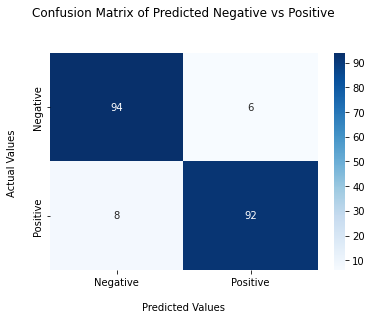

In [111]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix of Predicted Negative vs Positive\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values \n');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [112]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

[[0.2107801]]
negative
--------

[[0.946092]]
positive
--------

[[0.28097275]]
negative
--------



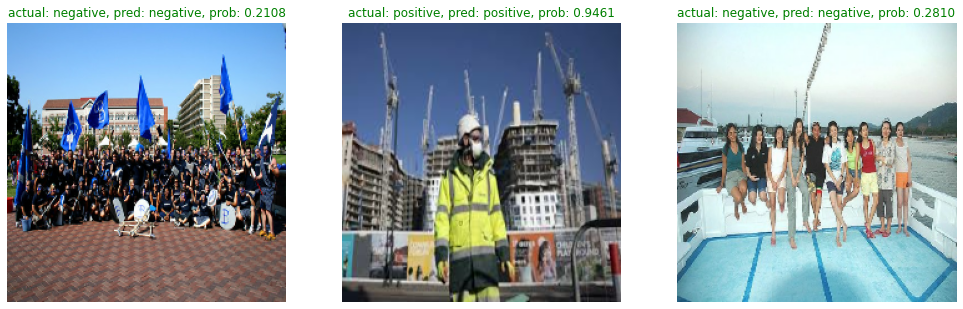

In [136]:
# Make preds on a series of random images from the test dataset
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image
  class_name = random.choice(test_data.class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  print(pred_prob)
   # find the predicted class
  if pred_prob < 0.5:
    pred_class = "negative"
  else:
    pred_class = 'positive' 
  print(pred_class)
  print('--------\n')

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.4f}", c=title_color)
  plt.axis(False);

In [138]:
os.listdir("classification/ambiguous")

['amb_2.jpg',
 'amb_1.jpg',
 'amb_10.jpg',
 'amb_7.jpg',
 'amb_5.jpg',
 'amb_6.jpg',
 'amb_8.jpg',
 'amb_4.jpg',
 'amb_9.jpg',
 'amb_3.jpg']

In [140]:
# Get ambiguous images filepaths (unseen data)
amb_images = ["classification/ambiguous/" + img_path for img_path in os.listdir("classification/ambiguous")]
amb_images


['classification/ambiguous/amb_2.jpg',
 'classification/ambiguous/amb_1.jpg',
 'classification/ambiguous/amb_10.jpg',
 'classification/ambiguous/amb_7.jpg',
 'classification/ambiguous/amb_5.jpg',
 'classification/ambiguous/amb_6.jpg',
 'classification/ambiguous/amb_8.jpg',
 'classification/ambiguous/amb_4.jpg',
 'classification/ambiguous/amb_9.jpg',
 'classification/ambiguous/amb_3.jpg']

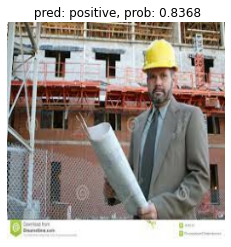

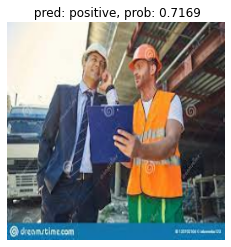

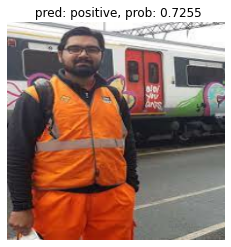

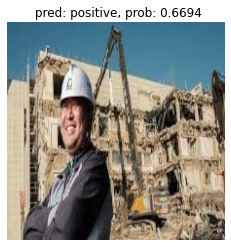

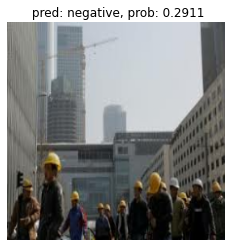

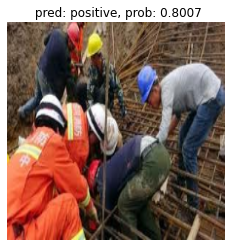

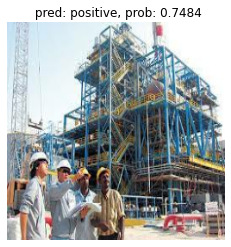

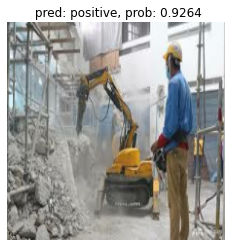

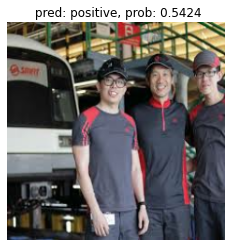

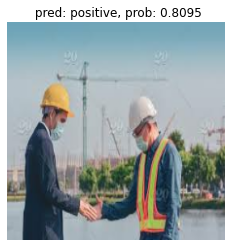

In [161]:
for img in amb_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  # find the predicted class
  if pred_prob < 0.5:
    pred_class = "negative"
  else:
    pred_class = 'positive' 

  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f" pred: {pred_class}, prob: {pred_prob.max():.4f}")
  plt.axis(False);